In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os

os.chdir('/content/drive/MyDrive/Colab Notebooks/4.2.2')

Mounted at /content/drive


# 4.4.2 a:

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.signal import detrend
from scipy.fftpack import dct
from sklearn.utils import shuffle

###############################################################################
#   1) generate_data
#   2) Define ConvNet1D (MaxPool, kernel size=500, out_channels=8)
#   3) Train 200 rounds and draw convolution kernel weights
###############################################################################

def generate_data(N=500, Xtot=10000, sl_multiplier=5):
    """
    Data generation equivalent to training_data_generation.m:
    Generate Xtot signal length N*sl_multiplier, each signal can contain 0 or 1~2 cosine components,
    The first 8 DCT coefficients (normalized) are constructed according to dct_ideal as labels.
    """
    step = (2*np.pi)/N
    t = np.arange(step, 2*np.pi*sl_multiplier + step, step)  # length = N*sl_multiplier
    length = N * sl_multiplier  # 2500
    trainX = np.zeros((Xtot, length))
    trainy = np.zeros((Xtot, 8))

    for i in range(Xtot):
        if i % 1000 == 0:
            print(f"[Data Generation] sample {i}")
        y_tot = np.random.randint(0, 31)  # [0, 30]
        dct_ideal = np.zeros(N)          # Used to count frequency components
        if y_tot == 0:
            y = np.ones(length)
            dct_ideal[0] = 1
        else:
            if y_tot > 2:
                y_tot = 1
            y = np.zeros(length)
            for _ in range(y_tot):
                f2 = np.random.randint(1, 8)  # [1,7]
                dct_ideal[f2] += 1
                f = f2 / 2.0
                time_add = (2*np.pi)/np.random.randint(1,51)
                y += np.cos(f * (t + time_add))
            y = detrend(y)

        # noise = 0
        noise = np.zeros_like(y)
        y = y + noise

        # dct_ideal(1)*=2
        dct_ideal[0] *= 2

        # The first 8 coefficients are taken and normalized by Min-Max
        eight = dct_ideal[:8]
        mi, ma = eight.min(), eight.max()
        if abs(ma - mi) < 1e-9:
            scaled = np.zeros(8)
        else:
            scaled = (eight - mi)/(ma - mi)

        trainX[i,:] = y
        trainy[i,:] = scaled

    return trainX, trainy

# Define original network(MaxPool)
class ConvNet1D_MaxPool(nn.Module):
    def __init__(self, kernel_size=500, n_out=8, L_out=2001):
        super(ConvNet1D_MaxPool, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=n_out,
                               kernel_size=kernel_size, padding=0)
        self.pool = nn.MaxPool1d(L_out)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.conv1(x)       # -> (batch, n_out, L_out)
        out = torch.abs(out)      # magnitude spectra
        out = self.pool(out)      # -> (batch, n_out, 1)
        out = out.view(out.size(0), -1)  # (batch, n_out)
        out = self.softmax(out)
        return out

def train_4p2p2a():
    # 1) generated data
    N = 500
    Xtot = 10000
    sl_multiplier = 5
    trainX, trainy = generate_data(N, Xtot, sl_multiplier)
    trainX, trainy = shuffle(trainX, trainy)

    # 2) Set training parameters
    num_epochs = 200
    batch_size = 30
    learning_rate = 1e-6
    kernel_size = 500
    n_out = 8
    L_in = trainX.shape[1]            # 2500
    L_out = L_in - kernel_size + 1    # 2001

    # 3) Define network, loss, optimizer
    model = ConvNet1D_MaxPool(kernel_size=kernel_size, n_out=n_out, L_out=L_out)
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 4) Change to torch.Tensor
    trainXT = torch.from_numpy(trainX.astype('float32')).unsqueeze(1)  # (Xtot,1,2500)
    trainyT = torch.from_numpy(trainy.astype('float32'))               # (Xtot,8)

    # 5) Train 200 epochs
    Ndata = trainXT.shape[0]
    loss_list = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for i in range(0, Ndata, batch_size):
            x_batch = trainXT[i:i+batch_size, :, :]
            y_batch = trainyT[i:i+batch_size, :]
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / (Ndata // batch_size)
        loss_list.append(avg_loss)
        if (epoch+1) % 10 == 0:
            print(f"[4.2.2a] Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

    # 6) Plotting training loss
    plt.figure(figsize=(6,4))
    plt.plot(loss_list, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('L1 Loss')
    plt.title('4.2.2a: Training Loss (MaxPool, 200 epochs)')
    plt.grid(True)
    plt.legend()
    plt.show()

    # 7) Plotting training loss
    kernels = model.conv1.weight.detach().cpu().numpy()  # shape: (8,1,500)
    fig, axs = plt.subplots(n_out, 1, figsize=(8,10), sharex=True)
    fig.suptitle('4.2.2a: Converged Kernel Weights After 200 Epochs', fontsize=14)
    for i in range(n_out):
        axs[i].plot(kernels[i,0,:], label=f'Kernel {i}')
        axs[i].legend(loc='upper right')
        axs[i].grid(True)
    plt.tight_layout()
    plt.show()

    return trainXT, trainyT, L_out



# 4.4.2 b

[Data Generation] sample 0
[Data Generation] sample 1000
[Data Generation] sample 2000
[Data Generation] sample 3000
[Data Generation] sample 4000
[Data Generation] sample 5000
[Data Generation] sample 6000
[Data Generation] sample 7000
[Data Generation] sample 8000
[Data Generation] sample 9000
[4.2.2a] Epoch 10/200, Loss: 0.1910
[4.2.2a] Epoch 20/200, Loss: 0.1599
[4.2.2a] Epoch 30/200, Loss: 0.1337
[4.2.2a] Epoch 40/200, Loss: 0.1122
[4.2.2a] Epoch 50/200, Loss: 0.0939
[4.2.2a] Epoch 60/200, Loss: 0.0782
[4.2.2a] Epoch 70/200, Loss: 0.0649
[4.2.2a] Epoch 80/200, Loss: 0.0539
[4.2.2a] Epoch 90/200, Loss: 0.0448
[4.2.2a] Epoch 100/200, Loss: 0.0373
[4.2.2a] Epoch 110/200, Loss: 0.0311
[4.2.2a] Epoch 120/200, Loss: 0.0260
[4.2.2a] Epoch 130/200, Loss: 0.0218
[4.2.2a] Epoch 140/200, Loss: 0.0185
[4.2.2a] Epoch 150/200, Loss: 0.0157
[4.2.2a] Epoch 160/200, Loss: 0.0135
[4.2.2a] Epoch 170/200, Loss: 0.0117
[4.2.2a] Epoch 180/200, Loss: 0.0103
[4.2.2a] Epoch 190/200, Loss: 0.0091
[4.2.2a] 

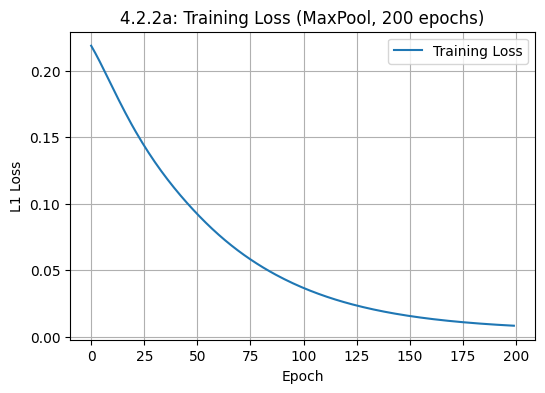

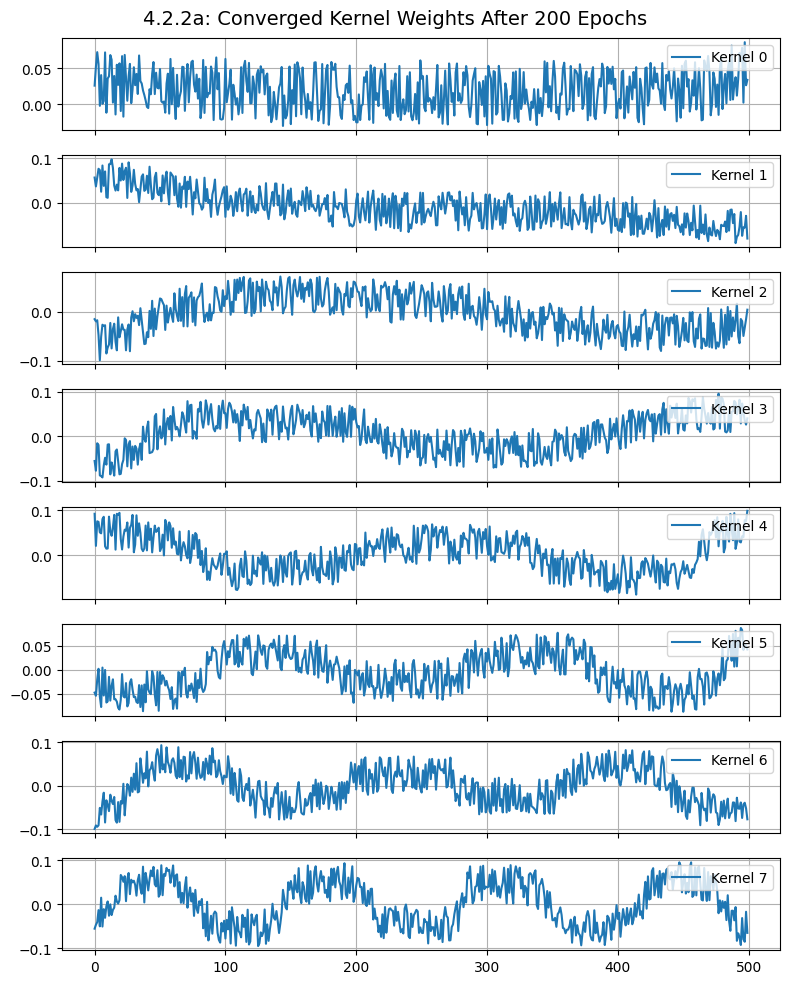

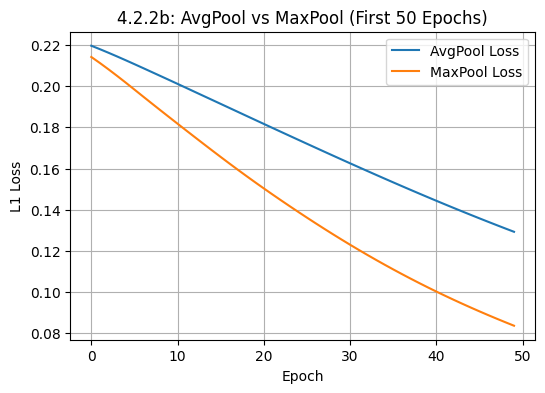

In [ ]:
###############################################################################
#   1) Compare Average Pooling and Max Pooling
#   2) Only train 50 epochs, observe L1Loss
###############################################################################

class ConvNet1D_AvgPool(nn.Module):
    def __init__(self, kernel_size=500, n_out=8, L_out=2001):
        super(ConvNet1D_AvgPool, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=n_out,
                               kernel_size=kernel_size, padding=0)
        self.pool = nn.AvgPool1d(L_out)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.conv1(x)
        out = torch.abs(out)
        out = self.pool(out)            # (batch, n_out, 1)
        out = out.view(out.size(0), -1) # (batch, n_out)
        out = self.softmax(out)
        return out

def train_4p2p2b(trainXT, trainyT, L_out, num_epochs=50, batch_size=30, lr=1e-6):
    """
    Compare AvgPool 与 MaxPool, only train 50 epochs.
    """
    # Define two net
    model_avg = ConvNet1D_AvgPool(kernel_size=500, n_out=8, L_out=L_out)
    model_max = ConvNet1D_MaxPool(kernel_size=500, n_out=8, L_out=L_out)

    criterion = nn.L1Loss()
    opt_avg = optim.Adam(model_avg.parameters(), lr=lr)
    opt_max = optim.Adam(model_max.parameters(), lr=lr)

    Ndata = trainXT.shape[0]
    loss_list_avg = []
    loss_list_max = []

    for epoch in range(num_epochs):
        epoch_loss_avg = 0.0
        epoch_loss_max = 0.0

        for i in range(0, Ndata, batch_size):
            x_batch = trainXT[i:i+batch_size, :, :]
            y_batch = trainyT[i:i+batch_size, :]

            # AvgPool
            opt_avg.zero_grad()
            outputs_avg = model_avg(x_batch)
            loss_avg = criterion(outputs_avg, y_batch)
            loss_avg.backward()
            opt_avg.step()
            epoch_loss_avg += loss_avg.item()

            # MaxPool
            opt_max.zero_grad()
            outputs_max = model_max(x_batch)
            loss_max = criterion(outputs_max, y_batch)
            loss_max.backward()
            opt_max.step()
            epoch_loss_max += loss_max.item()

        avgL_avg = epoch_loss_avg / (Ndata // batch_size)
        avgL_max = epoch_loss_max / (Ndata // batch_size)
        loss_list_avg.append(avgL_avg)
        loss_list_max.append(avgL_max)

    # Plot
    plt.figure(figsize=(6,4))
    plt.plot(loss_list_avg, label='AvgPool Loss')
    plt.plot(loss_list_max, label='MaxPool Loss')
    plt.xlabel('Epoch')
    plt.ylabel('L1 Loss')
    plt.title('4.2.2b: AvgPool vs MaxPool (First 50 Epochs)')
    plt.legend()
    plt.grid(True)
    plt.show()


def main():
    trainXT, trainyT, L_out = train_4p2p2a()
    train_4p2p2b(trainXT, trainyT, L_out, num_epochs=50)

if __name__ == "__main__":
    main()
